# numerically solving differential equations

**learning objectives:**
* use `DifferentialEquations.jl` (documentation [here](https://docs.juliadiffeq.org/stable/index.html)) to compute the numerical solution to differential equations. differential equations often govern the time-evolution of a variable characterizing a real-life process in chemical engineering. differential equations usually arise from mass or energy balances in chemical engineering.
* equip yourself with a conceptual understanding of process dynamics, in the context of our simple saline production facility.

In [12]:
using DifferentialEquations, PyPlot

# (optional) change to a cool plot style. 
# see here for options: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

## saline solution production
the following differential equation is a dynamic model for a process for salt water production (see lecture notes):

\begin{equation}
    V \frac{dc}{dt} = w - qc
\end{equation}

<img src="https://raw.githubusercontent.com/SimonEnsemble/control_theory_demos/master/studios/salt_mixer.png" width=400>

* $V$ [L]: volume of liquid in the tank (constant as a consequence of the overflow line)
* $c$ [g/L]: concentration of salt in the solution
* $q$ [L/s]: incoming volumetric flow rate of pure water
* $w$ [g/s]: incoming gravimetric flow rate of solid salt granules

we will simulate the dynamics of this process-- i.e., we will numerically solve the ODE to arrive at the salt concentration as a function of time, $c(t)$, under two different scenarios below.

in each scenario, the volume of liquid hold-up in the tank is constant at $V=10$ L, and the incoming flow rate of water is $q=0.1$ L/s (constant, not a function of time). thus, go ahead and define the variables `V` and `q` in the cell below. use an inline comment `#` to reiterate what the variable represents and indicate its units.

In [13]:
V = 10.0 # volume of liquid in tank, L
q = 0.1 # incoming flow rate of water, L/s

0.1

### (1) process start-up

First, we simulate process-start up. Because of a prior rinse, the tank is initially full with pure water devoid of salt. Then, suddenly, at time $t=0$, the constant-speed conveyor belt is turned on and $w$ [g/s] is maintained at a constant value.

(a) the customer demands a salt concentration of $c=0.1$ g/L. what should the incoming salt flow rate, $w$ [g/s], be specified as, then? assume that we can only program the conveyer belt to maintain a *constant* speed that results in this (constant) $w$.

In [14]:
c∞ = 0.1 # desired salt concentration, g/L
# at steady-state, dc/dt = 0. ==> w - q c∞ = 0. solve for w to get the w that gives us the desired c∞
w = q * c∞ # what we should set the incoming salt flow rate to, g/s

0.010000000000000002

(b) sketch out on a piece of paper what you suspect $c(t)$ will look like in this scenario.

(c) use `DifferentialEquations.jl` to simulate $c(t)$, the concentration of salt in the water coming out of the process, for $t\in[0, 10]$ minutes. plot $c(t)$ for the same time span, from start-up ($t=0$) to $t=10$ minutes. also plot a black, vertical, dashed line at $c=0.1$ to confirm that the limiting value of $c(t)$ corresponds to the concentration that the customer desires (hint: try `axhline(y=0.1, color="black", linestyle="--")` for a horizontal line).

(d) did the concentration profile match your expectations? why or why not?

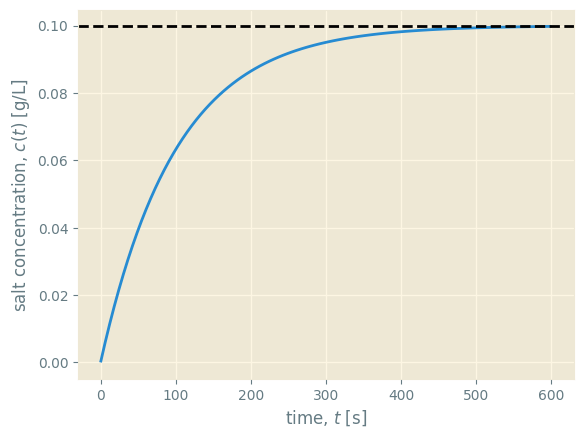

PyObject <matplotlib.lines.Line2D object at 0x7fc7d71a6080>

In [16]:
# initial condition
c₀ = 0.0 # g/L

# right hand side (we're not using p = parameters, t = time here, but DifferentialEquations.jl uses this form)
f(c, p, t) = (w - q * c) / V

# DifferentialEquations.jl syntax
time_span = (0.0, 60.0*10) # solve from t = 0 to t = 10 min
prob = ODEProblem(f, c₀, time_span)
c_of_t = solve(prob)

# plot solution
t = range(0.0, time_span[2], length=100)
c = c_of_t.(t)

figure()
plot(t, c)
xlabel(L"time, $t$ [s]")
ylabel(L"salt concentration, $c(t)$ [g/L]")
axhline(y=c∞, color="black", linestyle="--")

(e)  [**ambitious Beavers**, an after studio question]: although the customer seeks $c=0.1$ g/L, the customer will accept (buy) saline solution that is in the range $c\in[0.095, 0.105]$.
* how long does it take for the process to output saline solution that is viable to sell?
* what volume of solution must we throw out, then, from the start-up phase where the concentration was not up to standards?

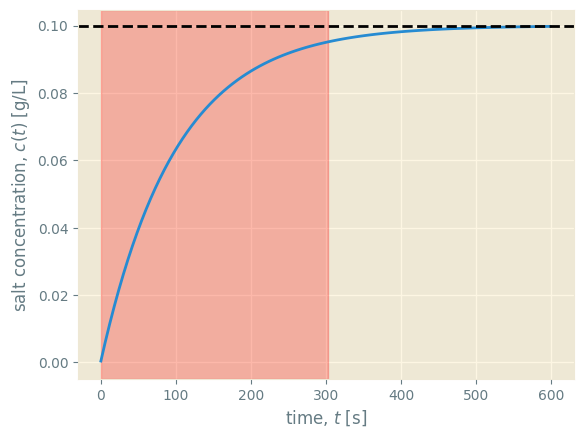

the saline solution reached a concentration of : 0.0951703823614496
	at time t = 303.030303030303 s
how much volume of solution was wasted, in Liters? 30.3030303030303


PyObject <matplotlib.patches.Polygon object at 0x7fc7d7110208>

In [17]:
# way 1: a for loop
for i = 1:length(t)
    if c[i] > 0.095
        println("the saline solution reached a concentration of : ", c[i])
        print("\tat time t = ", t[i])
        println(" s")
        println("how much volume of solution was wasted, in Liters? ", q * t[i])
        break
    end
end

# way 2: a Julian way
t₀ = t[findfirst(c .> 0.095)]

figure()
plot(t, c)
xlabel(L"time, $t$ [s]")
ylabel(L"salt concentration, $c(t)$ [g/L]")
axhline(y=c∞, color="black", linestyle="--")
axvspan(0.0, t₀, color="red", alpha=0.25)

### (2) a disturbance

the process is initially operating at steady state, with $c=0.1$ g/L, and maintains steady state conditions until $t=25$ s. At this point in time, the conveyor belt loses power and shuts off. Only at $t=100$ s does the engineer on staff address the problem and switch the conveyor belt back on to its normal speed. 

(a) $w=w(t)$ is a piecewise function here, also known as a rectangular pulse. sketch out what $w(t)$ looks like and write it mathematically as a piecewise function.

(b) code-up $w(t)$ as a `function` in Julia, `function w_pulse(t)`. you will need to use an `if` statement. the below example should teach you how to write an `if` statement in Julia.

```julia
x = 2

if x > 5
    println("x is greater than 5!")
else
    println("x is not greater than 5.")
end
```

add a cell and see what this code outputs. change `x` to be `10` and then see what happens.

you might also want to use `||` for "or". here is an example:

```julia
(x > 5) || (x < 3) # true
```

In [18]:
w̄ = 0.01 # steady state value of w, g/s

function w_pulse(t) # g/s
    if (t < 25) || (t > 100)
        return w̄
    else
        return 0.0
    end
end

w_pulse (generic function with 1 method)

(c) to be sure you coded up `w_pulse(t)` correctly, plot it to make sure it conforms to your expectations. it should look like a rectangular pulse!

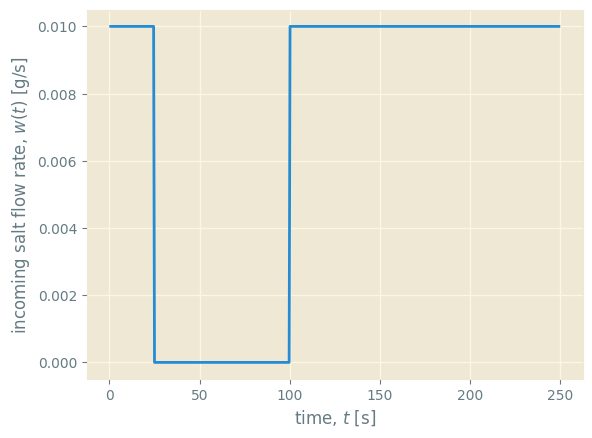

PyObject Text(32.000000000000014, 0.5, 'incoming salt flow rate, $w(t)$ [g/s]')

In [20]:
t = range(0.0, 250.0, length=500)

figure()
plot(t, w_pulse.(t))
xlabel(L"time, $t$ [s]")
ylabel(L"incoming salt flow rate, $w(t)$ [g/s]")

(d) sketch out on pencil and paper what you anticipate the solution $c(t)$ to look like with this rectangular pulse input.

(e) use `DifferentialEquations.jl` to simulate $c(t)$, the concentration of salt in the water coming out of the process, for $t\in[0, 10]$ minutes. plot $c(t)$ for the same time span, from start-up to 10 minutes. also plot a black, vertical, dashed line at $c=0.1$ g/L as before.

**hint**: when defining the right-hand-side of the ODE for `DifferentialEquations.jl`, you will need to use the time argument, `t`, in `f(c, p, t)` and pass it into your `w_pulse(t)`.

**hint**: you may see an unphysical blip in the solution, owing to a discontinuity in the input. to alleviate this numerical artifact, pass `d_discontinuities=[100.0, 25.0]` to `ODEProblem` to make sure it handles the discontinuities in the input appropriately.

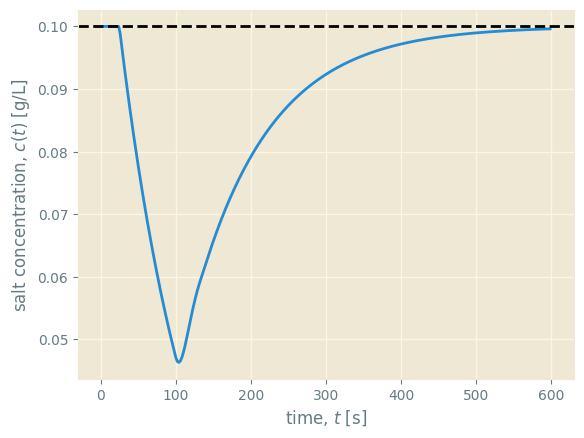

PyObject <matplotlib.lines.Line2D object at 0x7fc7d6fe2b70>

In [22]:
# initial condition
c₀ = 0.1 # g/L

# right hand side (we're not using p = parameters, t = time here, but DifferentialEquations.jl uses this form)
f(c, p, t) = (w_pulse(t) - q * c) / V

# DifferentialEquations.jl syntax
prob = ODEProblem(f, c₀, time_span, d_discontinuities=[100.0, 25.0])
c_of_t = solve(prob)

# plot solution
t = range(0.0, time_span[2], length=300)
c = c_of_t.(t)

figure()
plot(t, c)
xlabel(L"time, $t$ [s]")
ylabel(L"salt concentration, $c(t)$ [g/L]")
axhline(y=c∞, color="black", linestyle="--")

(f) does the solution $c(t)$ conform to your expectations?

(g) [**VERY ambitious Beavers**, an after studio question]: although the customer seeks $c=0.1$ g/L, the customer will accept (buy) saline solution that is in the range $c\in[0.095, 0.105]$. for how long are we producing salt water that cannot be sold to the customer?

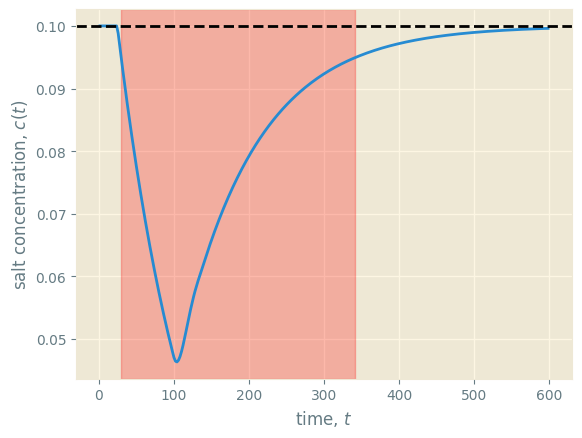

out of comission for how many seconds? 311.03678929765886


PyObject <matplotlib.patches.Polygon object at 0x7fc7d6f4fd30>

In [23]:
t₀ = t[findfirst(c .< 0.095)]
t₁ = t[findlast(c .< 0.095)]
println("out of comission for how many seconds? ", t₁ - t₀)

figure()
plot(t, c)
xlabel(L"time, $t$")
ylabel(L"salt concentration, $c(t)$")
axhline(y=c∞, color="black", linestyle="--")
axvspan(t₀, t₁, color="red", alpha=0.25)